Goals for this code segment
1. Get data into daily format
2. Feed into fbprophet 
3. Test on testing portion of dataset

BONUS: Tune hyperparamters (it seems fbprophets defaults are decent without adjustments)

In [1]:
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
from tabulate import tabulate
import os
import math
import regex as re 
from selenium.webdriver.support.ui import Select

from zipfile import ZipFile
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from decimal import Decimal
import numpy as np
import pandas as pd
import math
import os
import io
from sklearn.metrics import mean_squared_error

from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import r2_score
import boto3 

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Importing plotly failed. Interactive plots will not work.


In [2]:
#import data
type_dict = {'user_type': 'str', 'bike_share_for_all_trip': 'str'}
df = pd.read_csv('aws_data/final_data_download.csv', parse_dates = ['start_time', 'end_time'])
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()/60


C:\Users\gadde\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
#Aggregate duration totals to daily amounts to prep for modeling
df_modeling = pd.DataFrame()
df_modeling['ds'] = df['start_time'].dt.to_period('d')
df_modeling['y'] = df['duration']
df_modeling = df_modeling.groupby('ds').sum()

<AxesSubplot:>

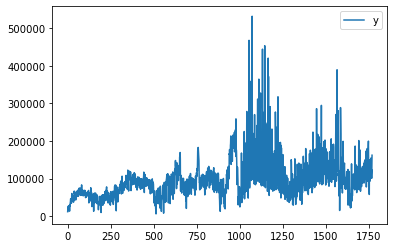

In [12]:
#Let us plot the numbers before fitting
df_modeling.plot()
#Although this looks much more volatile than the Tableau Total view it is only because we are showing daily numbers
#If we instead group by month, the data does match the Tableau Total view, so there are no data issues here

In [26]:
df_modeling.index
df_modeling = df_modeling.reset_index(level=0)
df_modeling['ds'] = df_modeling['ds'].dt.to_timestamp('s')

In [28]:
#Let us keep all of 2022 for testing and rest of the data from training
train = df_modeling[df_modeling.ds.dt.year<2022]
test =  df_modeling[df_modeling.ds.dt.year==2022]

In [101]:
#Now lets start of FB model
m=Prophet(seasonality_mode='multiplicative')
m.fit(train)
future=m.make_future_dataframe(periods=len(test),freq='d')
forecast=m.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-06-28,40739.637724,-11692.174312,92318.336010,40739.637724,40739.637724,0.016027,0.016027,0.016027,-0.066822,-0.066822,-0.066822,0.082849,0.082849,0.082849,0.0,0.0,0.0,41392.560856
1,2017-06-29,40828.237038,-8478.343385,94780.731672,40828.237038,40828.237038,0.017235,0.017235,0.017235,-0.069782,-0.069782,-0.069782,0.087018,0.087018,0.087018,0.0,0.0,0.0,41531.922219
2,2017-06-30,40916.836351,-5418.565192,100562.217775,40916.836351,40916.836351,0.139654,0.139654,0.139654,0.046760,0.046760,0.046760,0.092895,0.092895,0.092895,0.0,0.0,0.0,46631.048360
3,2017-07-01,41005.435664,3912.714568,102914.179648,41005.435664,41005.435664,0.301275,0.301275,0.301275,0.200882,0.200882,0.200882,0.100393,0.100393,0.100393,0.0,0.0,0.0,53359.353042
4,2017-07-02,41094.034977,-6031.826491,100266.156531,41094.034977,41094.034977,0.178507,0.178507,0.178507,0.069110,0.069110,0.069110,0.109397,0.109397,0.109397,0.0,0.0,0.0,48429.627083


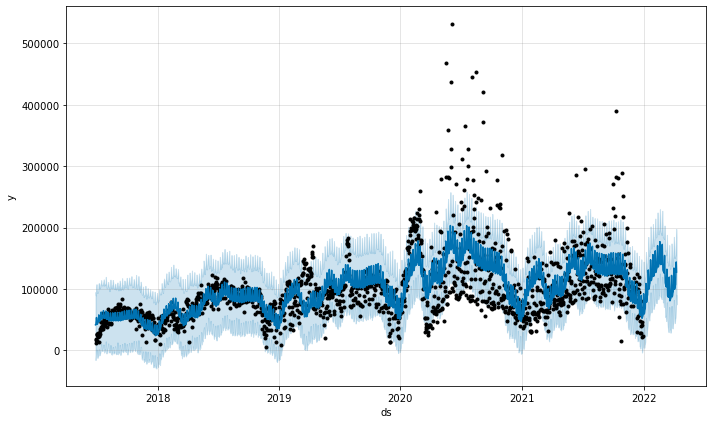

In [30]:
#plot our forecast
m.plot(forecast, uncertainty=True)
plt.show()

As one can see in the above plot, there is considerable variation in our results.

C:\Users\gadde\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\gadde\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


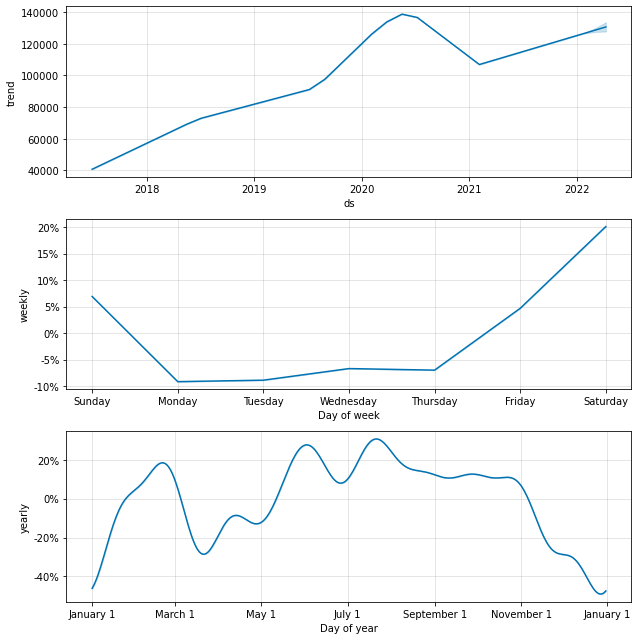

In [31]:
#Get components of our plot
fig=m.plot_components(forecast)


In [48]:
#Perform crossfold validation on training data. Note my training data 

print('This is the number of entries in the training dataset: ' + str(len(train)))


#Want to project 1 month out at a time and validate since that is the freq the new data will be coming in with


#The initial model will be trained up to the first cutoff point 
#It will forecast the next 30 days of data (because horizon is set to 30). 
#The model will then train on all values up to the next cutoff point in the data and forecast 30 days
#This will continue until the last cutoff is hit

cutoffs = pd.date_range(start='2021-01-01', end='2021-12-01', freq='MS')
cutoffs

fb_cv=cross_validation(m, horizon= '30 day', cutoffs = cutoffs)


This is the number of entries in the training dataset: 1648


  0%|          | 0/12 [00:00<?, ?it/s]

In [49]:
# Performance Metrics of fb_cv
#In the Output performance metrics you can see metric value for the forecast done for X days to the future. 
#For example in the 1st line (horizon = 2 days) you see what are the metrics for forecast 2 days ahead.
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.479689e+09,49796.476490,39290.467469,0.420574,0.283896,0.722222
1,4 days,1.893589e+09,43515.386815,35478.810938,0.378194,0.259976,0.750000
2,5 days,1.578016e+09,39724.245595,31636.448686,0.346038,0.232705,0.777778
3,6 days,1.386723e+09,37238.732650,28270.154817,0.286912,0.179130,0.833333
4,7 days,1.780831e+09,42199.889961,30927.805605,0.340354,0.202741,0.805556
5,8 days,4.070250e+09,63798.508242,41505.279169,0.407615,0.257850,0.777778
6,9 days,5.932619e+09,77023.496024,52249.018071,0.473908,0.333151,0.666667
7,10 days,5.915681e+09,76913.465792,53138.178573,0.527102,0.336232,0.638889
8,11 days,4.888555e+09,69918.203121,50869.546085,0.561845,0.272840,0.583333
9,12 days,3.386796e+09,58196.185564,43810.039507,0.536817,0.272840,0.583333


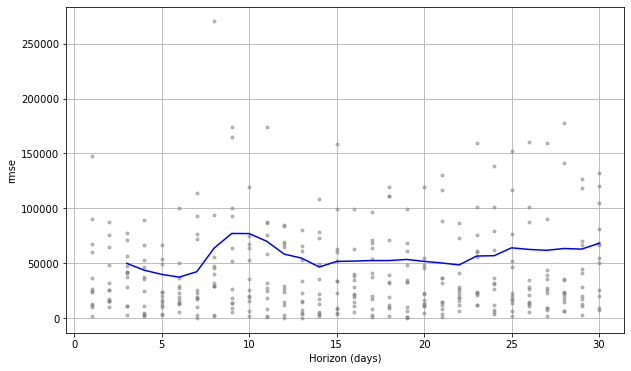

In [51]:
plot_cross_validation_metric(fb_cv,'rmse');

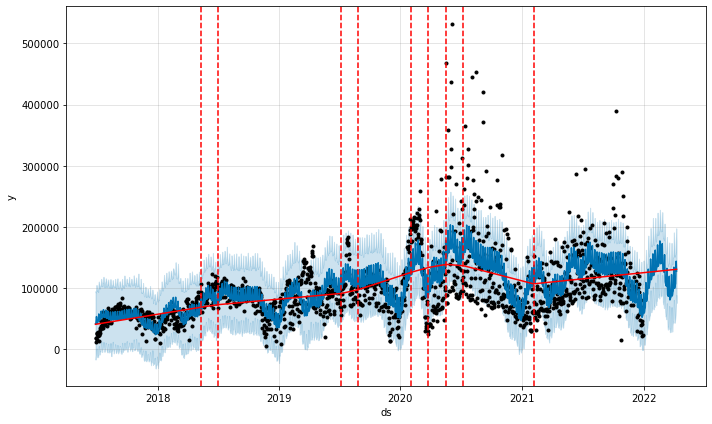

In [52]:
# changing trend points
from fbprophet.plot import add_changepoints_to_plot
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)

Now our goal is to determine the persistent forecast on the test data. We will use mean absolute error as our metric of interest. Our naive forecast will assume the value at t+1 is predicted to be the value of t
(e.g. our prediction is simply the last datapoint with no adjusments made)

We will have to create a lagged dataset for this purpose

In [93]:
test_lagged = pd.concat([test.iloc[:,1].shift(1), test.iloc[:,1]], axis = 1)
#Walk forward validation
from sklearn.metrics import mean_squared_error
test_lagged.dropna(inplace = True)
Persistent_test_score = mean_squared_error(test_lagged.iloc[:,0], test_lagged.iloc[:,1])
print('Persistent forecast MAE is ' + "{:,}".format(round(test_score,0)))

Persistent forecast MAE is 1,178,871,053.0


In [111]:
#Now lets see what the MAE on the test dataset is with our time series model is
#Here are my time series predictions for the test interval
values = forecast[['ds','yhat']].tail(len(test)-1)
Model_test_score = mean_squared_error(values['yhat'], test_lagged.iloc[:,1])
print('Model forecast MAE is ' + "{:,}".format(round(Model_test_score,0)))

Model forecast MAE is 1,027,646,177.0


Sadly it doesn't seem like the fbprophet time series reduces the MAE by that much compared to the persistent forecast. We can revisit this in the future by tuning the model. Be careful not to validate against the test dataset since that should be left until the very end. For validation purposes, cross-fold validation should be enough